1. Попробуйте обучить нейронную сеть LSTM на любом другом датасете(любимый временной ряд, текст на русском(другом языке)как генератор или классификатор, или предлагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?
2. *Попробуйте на numpy реализовать сеть архитектуры LSTM
3. *Предложите свои варианты решения проблемы исчезающего градиента в RNN

In [110]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [111]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

import seaborn as sns
mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

In [112]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [113]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    # rolling_std =  series.rolling(window=n).std()
    # upper_bond = rolling_mean+1.96*rolling_std
    # lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    # plt.plot(lower_bond, "r--")
    plt.plot(series[n:], label="Actual values", lw=0.5, alpha=.5)
    plt.legend(loc="upper left")
    plt.grid(True)

In [114]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
EPOCHS = 10
PATIENCE = 5

# Reproducibility
SEED = 13
tf.random.set_seed(SEED)

In [115]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
    )
csv_path, _ = os.path.splitext(zip_path)

In [116]:
df = pd.read_csv(csv_path)
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df = df[['T (degC)']]
df.index = date_time

In [117]:
df.head()

,T (degC)
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27


In [118]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28


In [119]:
# timestamp_s = date_time.map(pd.Timestamp.timestamp)

**Для примера, возьмем изменения температуры**

In [120]:
plotly_df(df[::500], title = "Temperature")# чтобы не загромождать график, возьмем каждое пятисотое наблюдение

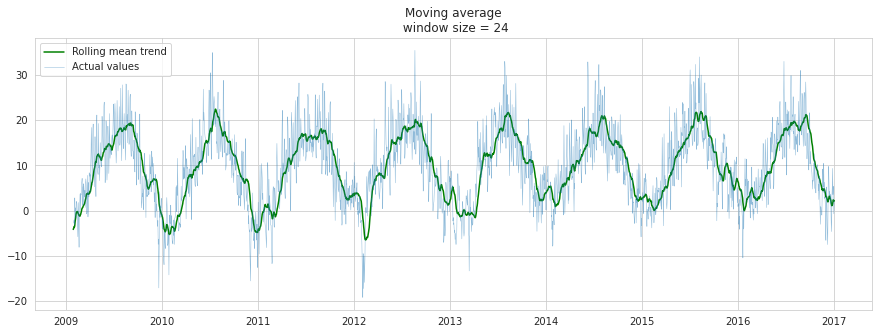

In [121]:
plotMovingAverage(df[::24 * 7], 24) 

In [122]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
        
    return np.array(data), np.array(labels)

In [123]:
uni_data = df['T (degC)']
uni_data.index = df.index
uni_data.head()

Date Time
2009-01-01 00:10:00   -8.02
2009-01-01 00:20:00   -8.41
2009-01-01 00:30:00   -8.51
2009-01-01 00:40:00   -8.31
2009-01-01 00:50:00   -8.27
Name: T (degC), dtype: float64

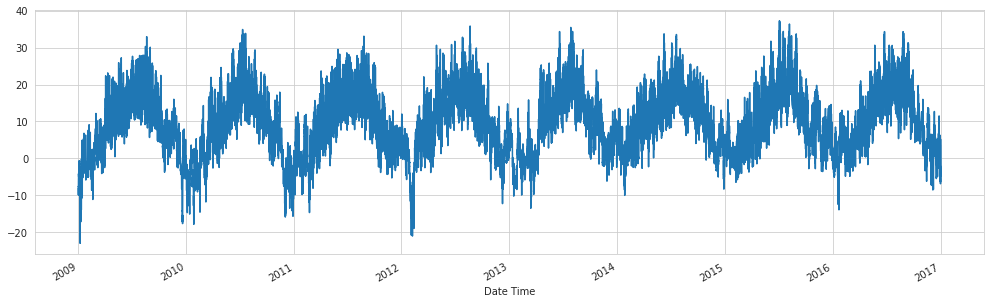

In [124]:
uni_data.plot(subplots=True)
plt.show()
uni_data = uni_data.values

In [125]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [126]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [127]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)
x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

In [128]:
print("In:")
print(uni_data.shape)
print(uni_data[:5])

print("\nOut")
print(x_train_uni.shape)


print(x_train_uni.shape[0] / uni_data.shape[0])

In:
(420551,)
[-1.99766294 -2.04281897 -2.05439744 -2.0312405  -2.02660912]

Out
(299980, 20, 1)
0.7133023105402199


In [129]:
print ('Single window of past history. Shape: {}'.format(x_train_uni[0].shape))
print (x_train_uni[0])
print ('\n Target temperature to predict. Shape: {}'.format(y_train_uni[0].shape))
print (y_train_uni[0])

Single window of past history. Shape: (20, 1)
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict. Shape: ()
-2.1041848598100876


In [130]:
def create_time_steps(length):
    return list(range(-length, 0))

In [131]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

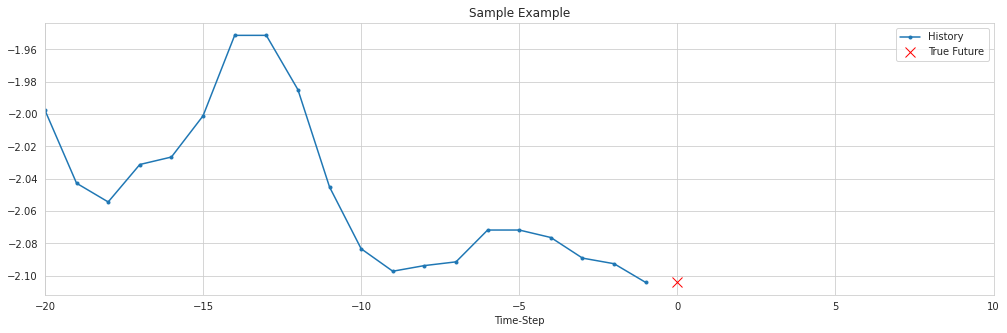

In [132]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

In [133]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

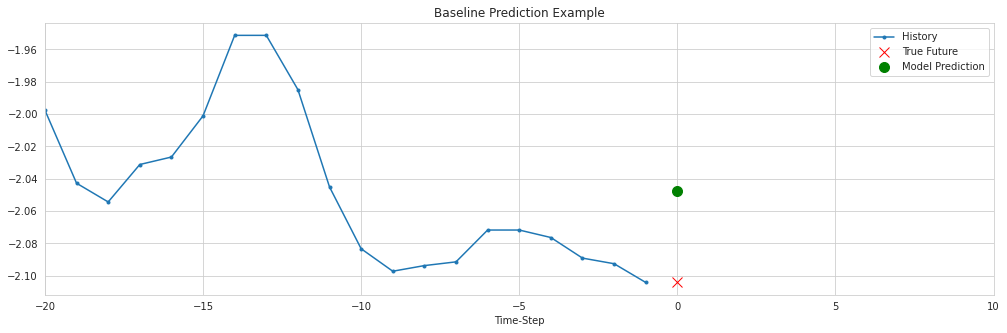

In [134]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example')

In [135]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [136]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [137]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)
simple_lstm_model.fit(train_univariate,
                      epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/10
200/200 [==============================] - 4s 14ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0286 - val_loss: 0.0207
Epoch 8/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0263 - val_loss: 0.0197
Epoch 9/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0253 - val_loss: 0.0181
Epoch 10/10
200/200 [==============================] - 2s 11ms/step - loss: 0.0227 - val_lo

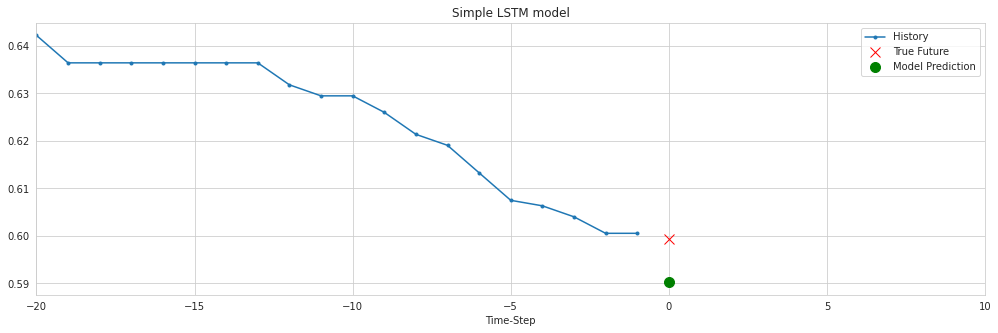

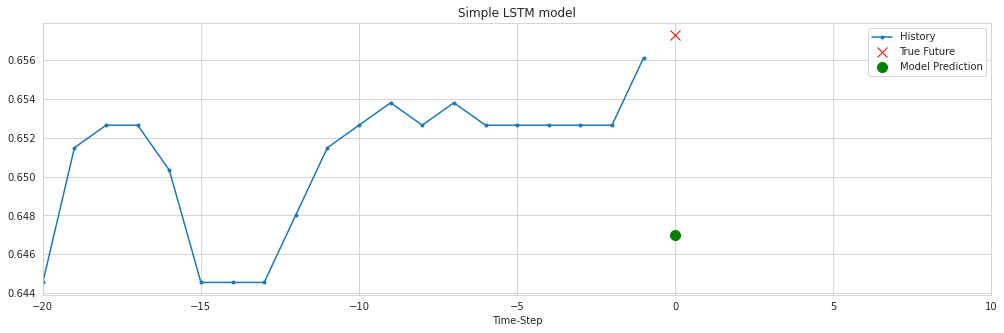

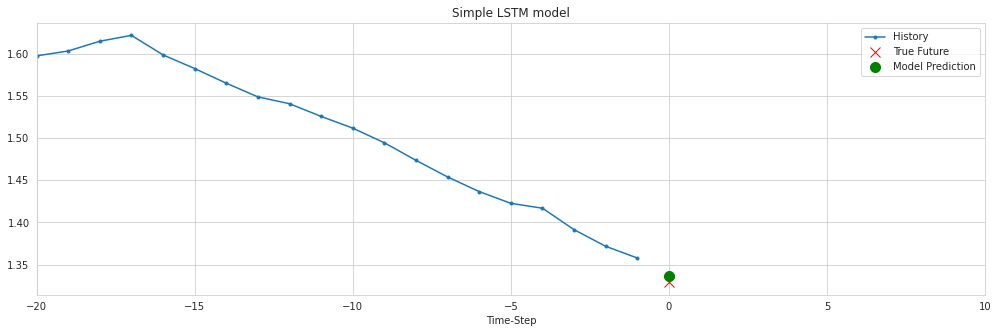

In [138]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [138]:
medium_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_uni.shape[-2:], return_sequences="True"),
    tf.keras.layers.LSTM(64, return_sequences="True"),
    tf.keras.layers.Conv1D(64, 3, activation="linear"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation="linear"),
    tf.keras.layers.Dense(1, activation="linear"),
])

medium_lstm_model.compile(optimizer='adam', loss='mae', metrics=['mae'])